In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt

# some SBML model
modelfile = '/gscratch/cheme/dalba/repos/ECFERS/models/MODEL6615119181.sbml'

r = te.loadSBMLModel(modelfile)
# r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))

# bin_model = 'model.b'
# r.saveState(bin_model)
# r.exportToSBML(modelfile[:-3]+'sbml')

parameter_values = r.getGlobalParameterValues()

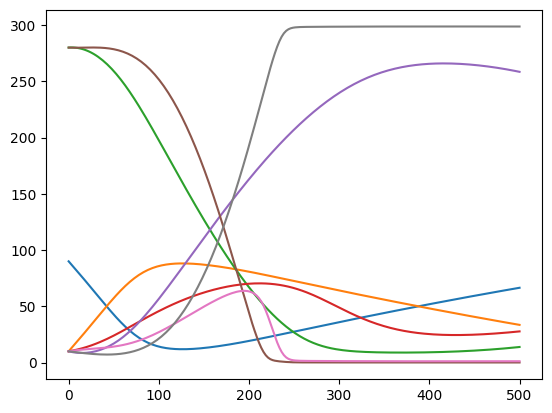

In [2]:
# new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
# r.model.setGlobalParameterValues(parameter_values)

result = r.simulate(0, 500, 200)
r.reset()
plt.plot(result[:,0], result[:,1:])
#plt.yscale('log')

In [3]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameters, settings):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = [i*10 for i in parameters]
        self.lowerb = [i/10 for i in parameters]

    def fitness(self, x):
        from roadrunner import Config
        Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
        Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
        Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)

        r = te.loadSBMLModel(self.model)
        for i,p in enumerate(x):
            try:
                r.model.setGlobalParameterValues([i], [p])
            except:
                pass
        # r.model.setGlobalParameterValues(x)
        
        try:
            results = r.simulate(**self.settings['simulation'])[:,1:].__array__()
        except:
            results = self.data*(-np.inf)
        return self._residual(results,self.data)

    # def _residual(self,results,data,points):
    #     md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
    #     mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
    #     denom = np.ones(data.shape)
    #     return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]

    def _residual(self,results,data):
        cols = self.settings['fit_to_cols']
        rows = self.settings['fit_to_rows']

        error = (data[:,cols][rows,:]-results[:,cols][rows,:])
        RMSE = np.sqrt(np.sum(error**2, axis=0)/len(rows))
        NRMSE = RMSE/(np.max(data[:,cols][rows,:], axis=0) - np.min(data[:,cols][rows,:], axis=0))
        return [np.sum(NRMSE)]

    def get_bounds(self):
        return (self.lowerb, self.upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [4]:
class my_bfe(pg.ipyparallel_bfe):
    def __init__(self, client_kwargs, view_kwargs):
        self.client_kwargs = client_kwargs
        self.view_kwargs = view_kwargs
        super().__init__()

    def init_view(self,client_args=[], client_kwargs={}, view_args=[], view_kwargs={}):
        with pg.ipyparallel_bfe._view_lock:
            if pg.ipyparallel_bfe._view is None:
                # Create the new view.
                from ipyparallel import Client
                rc = Client(*client_args, **client_kwargs)
                rc[:].use_cloudpickle()
                pg.ipyparallel_bfe._view = rc.broadcast_view(*view_args, **view_kwargs)

    def __call__(self, prob, dvs):

        import pickle
        import numpy as np
        from decorator import decorator
        
        # Fetch the dimension and the fitness
        # dimension of the problem.
        ndim = prob.get_nx()
        nf = prob.get_nf()

        # Compute the total number of decision
        # vectors represented by dvs.
        ndvs = len(dvs) // ndim
        # Reshape dvs so that it represents
        # ndvs decision vectors of dimension ndim
        # each.
        dvs.shape = (ndvs, ndim)

        # Pre-serialize the problem.
        pprob = pickle.dumps(prob)

        # Build the list of arguments to pass
        # to the cluster nodes.
        async_args = [(pprob, pickle.dumps(dv)) for dv in dvs]

        with pg.ipyparallel_bfe._view_lock:
            if pg.ipyparallel_bfe._view is None:
                pg.ipyparallel_bfe._view = self.init_view(self.client_kwargs, self.view_kwargs)

            @decorator
            def sync_results(f, view, *args, **kwargs):
                """sync relevant results from self.client to our results attribute."""
                if view._in_sync_results:
                    return f(view, *args, **kwargs)
                view._in_sync_results = True
                try:
                    ret = f(view, *args, **kwargs)
                finally:
                    view._in_sync_results = False
                    view._sync_results()
                return ret
            
            def _mp_ipy_bfe_func(ser_prob_dv):
                # The function that will be invoked
                # by the individual processes/nodes of mp/ipy bfe.
                import pickle
                # if len(ser_prob_dv) > 0:
                prob = pickle.loads(ser_prob_dv[0])
                dv = pickle.loads(ser_prob_dv[1])
                return pickle.dumps(prob.fitness(dv))
                # else:
                #     return
            
            @sync_results
            def map(view, f, *sequences):
                assert len(sequences) > 0, "must have some sequences to map onto!"
                pf = ipp.ParallelFunction(view, f, block=False, track=False, return_exceptions=True)
                return pf.map(*sequences)
            
            ret = map(pg.ipyparallel_bfe._view, _mp_ipy_bfe_func, async_args)
            # pg.ipyparallel_bfe._view.scatter('args', async_args)
            # ret = pg.ipyparallel_bfe._view.apply_async(lambda args: _mp_ipy_bfe_func(args), ipp.Reference('args'))
            
        # Build the vector of fitness vectors as a 2D numpy array.
        fvs = np.array([pickle.loads(fv) for fv in [x for x in ret.get() if x is not None]])
        # Reshape it so that it is 1D.
        fvs.shape = (ndvs*nf,)

        return fvs
        

In [4]:
import ipyparallel as ipp
cluster = ipp.Cluster(n=40, cluster_id='', profile='local')
cluster.start_and_connect_sync()
rc = cluster.connect_client_sync()
rc.wait_for_engines(40)

Starting 40 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.71engine/s]


In [10]:
udi = pg.ipyparallel_island()
udi.init_view(client_kwargs={'profile':'local'})

# udbfe = my_bfe(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs={'is_coalescing':True})
# udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs={'is_coalescing':True})
udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})
mybfe = pg.bfe(udbfe)

a = pg.pso_gen(gen=10)
a.set_bfe(mybfe)
algo = pg.algorithm(a)
algo.set_verbosity(1)

# pick a number of data points to fit to
settings = {'fit_to_cols':list(np.random.choice(r.getNumFloatingSpecies(),(r.getNumFloatingSpecies()//1),replace=False))}
settings['fit_to_rows'] = list(map(int, np.linspace(0,199-1,10)))
settings['simulation'] = {'start':0, 'end':500, 'points':200}

prob = pg.problem(SBMLGlobalFit(model = modelfile, data = result[:,1:].__array__(), parameters=parameter_values, settings=settings))

In [11]:
islands = [pg.island(udi = udi, algo = algo, prob = prob, size=75, b = mybfe, r_pol = pg.fair_replace(0.0), s_pol = pg.select_best(0.0)) for _ in range(8)]

KeyboardInterrupt: 

In [11]:
islands[0].evolve()
islands[0].wait_check()

In [38]:
archi = pg.archipelago(n=0,t=pg.ring())
[archi.push_back(i) for i in islands]
res =  []

In [39]:
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
for i in range(100):
    print(now() + ' - Starting evolution ' + str(i))
    archi.evolve()
    archi.wait_check()
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min(archi.get_champions_f())))
    res.append(np.array([a.get_algorithm().extract(pg.pso_gen).get_log() for a in archi]))
results = np.concatenate(res,axis=1)

29-01-2024, 02:26:40 - Starting evolution 0


RuntimeError: The asynchronous evolution of a pythonic island of type 'Ipyparallel island' raised an error:
Traceback (most recent call last):
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/pygmo/_py_islands.py", line 617, in run_evolve
    return loads(ret.get())
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/ipyparallel/client/asyncresult.py", line 357, in get
    raise e
  File "/opt/conda/envs/myenv/lib/python3.9/site-packages/ipyparallel/client/asyncresult.py", line 528, in _resolve_result
    raise r
ipyparallel.error.RemoteError: [23:apply] AttributeError: 'NoneType' object has no attribute '_in_sync_results'


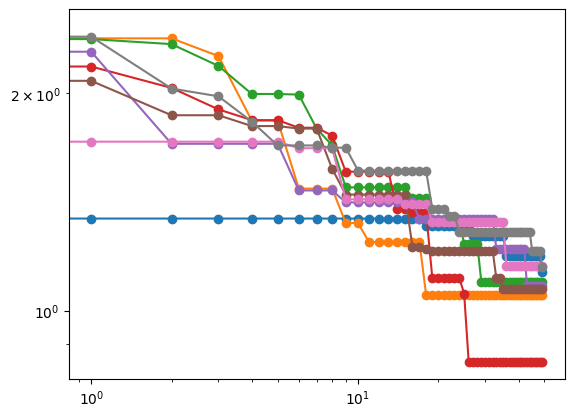

In [22]:
plt.plot(results[:,:,2].T,'o-')
plt.xscale('log')
plt.yscale('log')

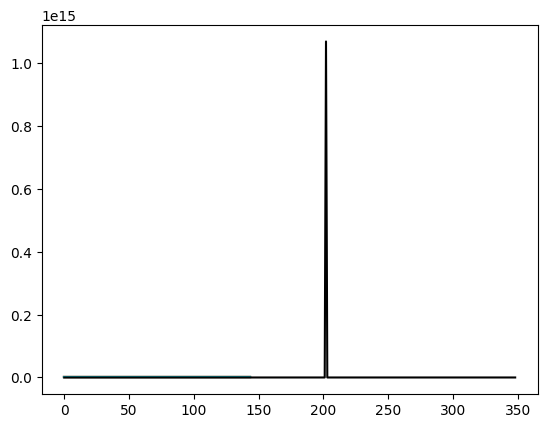

In [129]:
plt.plot(np.array(archi.get_champions_x()).T)
plt.plot(new_parameter_values,'k')

Text(0, 0.5, 'concentraion')

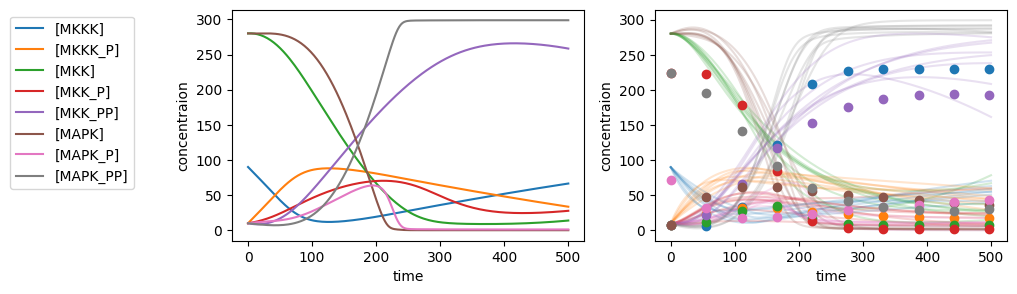

In [23]:
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
plt.figure(figsize=(10,3))
a = plt.subplot(1,2,1)
a.plot(result['time'],result[:,1:].__array__())
a.legend(result.colnames[1:], bbox_to_anchor=(-0.65, 1), loc='upper left' )
a.set_xlabel('time')
a.set_ylabel('concentraion')
#a.set_yscale('log')

b = plt.subplot(1,2,2)
mean_result = result*0
for k,c in enumerate(archi.get_champions_x()):
    r.resetToOrigin()
    for i,p in enumerate(c):
        try:
            r.model.setGlobalParameterValues([i], [p])
        except Exception as e:
            pass
    try:
        result2 = r.simulate(0, 500, 200)
    except Exception as e:
        print(k)
        print(e)
        result2 = result*0
    mean_result += result2
    
    b.set_prop_cycle(color=colors)
    b.plot(result['time'], result2[:,1:].__array__(), alpha = 0.2)

b.set_prop_cycle(color=colors)
b.plot(result['time'][settings['fit_to_rows']], (mean_result[:,1:].__array__()/10)[:,settings['fit_to_cols']][settings['fit_to_rows'],:],'o')
b.set_xlabel('time')
b.set_ylabel('concentraion')
#b.set_yscale('log')

In [23]:
archi = pg.archipelago(n=10,t=pg.ring(), algo=algo, prob=prob, pop_size=120, udi = udi, b = udbfe, r_pol = pg.fair_replace(0.02), s_pol = pg.select_best(0.02))
res =  []

for i in range(10):
    now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
    print(now() + ' - Starting evolution ' + str(i))
    archi.evolve()
    archi.wait_check()
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min(archi.get_champions_f())))
    res.append(np.array([a.get_algorithm().extract(pg.pso_gen).get_log() for a in archi]))
results2 = np.concatenate(res,axis=1)

28-01-2024, 02:15:33 - Starting evolution 0
28-01-2024, 02:22:09 - Evolution done. Best fitness: 32.55436413881443
28-01-2024, 02:22:09 - Starting evolution 1
28-01-2024, 02:28:44 - Evolution done. Best fitness: 26.497050702659507
28-01-2024, 02:28:44 - Starting evolution 2
28-01-2024, 02:35:22 - Evolution done. Best fitness: 26.497050702659507
28-01-2024, 02:35:22 - Starting evolution 3
28-01-2024, 02:41:57 - Evolution done. Best fitness: 24.357742584408296
28-01-2024, 02:41:57 - Starting evolution 4
28-01-2024, 02:48:29 - Evolution done. Best fitness: 24.357742584408296
28-01-2024, 02:48:29 - Starting evolution 5
28-01-2024, 02:55:15 - Evolution done. Best fitness: 24.357742584408296
28-01-2024, 02:55:15 - Starting evolution 6
28-01-2024, 03:02:04 - Evolution done. Best fitness: 24.2746565293212
28-01-2024, 03:02:04 - Starting evolution 7
28-01-2024, 03:08:50 - Evolution done. Best fitness: 24.2746565293212
28-01-2024, 03:08:50 - Starting evolution 8
28-01-2024, 03:15:39 - Evolution 

In [24]:
archi = pg.archipelago(n=10,t=pg.ring(), algo=algo, prob=prob, pop_size=120, udi = udi, b = udbfe, r_pol = pg.fair_replace(0.02), s_pol = pg.select_best(0.02))
res =  []

for i in range(10*5):
    now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
    print(now() + ' - Starting evolution ' + str(i))
    archi.evolve()
    archi.wait_check()
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min(archi.get_champions_f())))
    res.append(np.array([a.get_algorithm().extract(pg.pso_gen).get_log() for a in archi]))
results3 = np.concatenate(res,axis=1)

28-01-2024, 03:23:33 - Starting evolution 0
28-01-2024, 03:30:33 - Evolution done. Best fitness: 31.344589381714236
28-01-2024, 03:30:33 - Starting evolution 1
28-01-2024, 03:37:34 - Evolution done. Best fitness: 29.66104628815639
28-01-2024, 03:37:34 - Starting evolution 2
28-01-2024, 03:44:35 - Evolution done. Best fitness: 24.973520654956452
28-01-2024, 03:44:35 - Starting evolution 3
28-01-2024, 03:51:33 - Evolution done. Best fitness: 24.973520654956452
28-01-2024, 03:51:33 - Starting evolution 4
28-01-2024, 03:58:35 - Evolution done. Best fitness: 24.973520654956452
28-01-2024, 03:58:35 - Starting evolution 5
28-01-2024, 04:05:46 - Evolution done. Best fitness: 24.973520654956452
28-01-2024, 04:05:46 - Starting evolution 6
28-01-2024, 04:12:44 - Evolution done. Best fitness: 23.81625661167387
28-01-2024, 04:12:44 - Starting evolution 7
28-01-2024, 04:19:56 - Evolution done. Best fitness: 23.81625661167387
28-01-2024, 04:19:56 - Starting evolution 8
28-01-2024, 04:26:54 - Evolutio

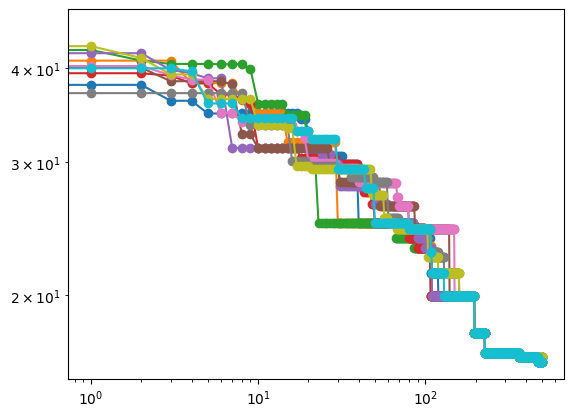

In [25]:
plt.plot(results3[:,:,2].T,'o-')
plt.xscale('log')
plt.yscale('log')

In [30]:
archi[0].get_population()

Problem name: Global Fitting of Multiple SBML Models
	C++ class name: pybind11::object

	Global dimension:			144
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0.0167, 0.0098, 0.0399, 0.213, 0.0008, ... ]
	Upper bounds: [1.67, 0.98, 3.99, 21.3, 0.08, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 144
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 60120
	Gradient evaluations: 0

	Thread safety: none

Population size: 120

List of individuals: 
#0:
	ID:			12202390506062812999
	Decision vector:	[0.296036, 0.584391, 0.589452, 13.7911, 0.000951712, ... ]
	Fitness vector:		[16.3364]
#1:
	ID:			12202390506062812999
	Decision vector:	[0.296036, 0.584391, 0.589452, 13.7911, 0.000951712, ... ]
	Fitness vector:		[16.3364]
#2:
	ID:			12202390506062812999
	Decision